In [1]:
import cv2
import os
import torch
from torch.utils.data import DataLoader,Dataset
from torchvision import datasets, transforms
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from torch import nn
import pandas as pd


In [2]:
# Setting path to get training and testing data
dataset_path = Path('icg-freshers-data-science-competition/Dataset/')
train_path = dataset_path/"Train"
test_path = dataset_path/"Test"

In [3]:
# Checking if things are working according to plan.
train_images = list(train_path.glob("*/*/*.png"))
test_images = list(test_path.glob("*.png"))
train_images

[PosixPath('icg-freshers-data-science-competition/Dataset/Train/Zeroes_and_Crosses/Zeroes/594.png'),
 PosixPath('icg-freshers-data-science-competition/Dataset/Train/Zeroes_and_Crosses/Zeroes/611.png'),
 PosixPath('icg-freshers-data-science-competition/Dataset/Train/Zeroes_and_Crosses/Zeroes/607.png'),
 PosixPath('icg-freshers-data-science-competition/Dataset/Train/Zeroes_and_Crosses/Zeroes/597.png'),
 PosixPath('icg-freshers-data-science-competition/Dataset/Train/Zeroes_and_Crosses/Zeroes/614.png'),
 PosixPath('icg-freshers-data-science-competition/Dataset/Train/Zeroes_and_Crosses/Zeroes/599.png'),
 PosixPath('icg-freshers-data-science-competition/Dataset/Train/Zeroes_and_Crosses/Zeroes/596.png'),
 PosixPath('icg-freshers-data-science-competition/Dataset/Train/Zeroes_and_Crosses/Zeroes/601.png'),
 PosixPath('icg-freshers-data-science-competition/Dataset/Train/Zeroes_and_Crosses/Zeroes/618.png'),
 PosixPath('icg-freshers-data-science-competition/Dataset/Train/Zeroes_and_Crosses/Zeroes/6

In [4]:
len(train_images),len(test_images)   #--> Checking if I am getting the complete data.

(50, 4495)

In [5]:
img = Image.open(train_images[2])
np.asarray(img).shape  #Shape of the image

(28, 28)

In [6]:

#! This piece of code tells how to modify each image to make it compatible to feed into the model
data_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5), # p = probability of flip, 0.5 = 50% chance
    # Turn the image into a torch.Tensor
    transforms.ToTensor() #This converts image into tensor ,#!this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0 
])

In [7]:
# traindata contains my images converted into tensors, along with their respective labels.
train_data = datasets.ImageFolder(root=Path.joinpath(train_path,"Zeroes_and_Crosses"), # target folder of images
                                  transform=data_transform, # transforms to perform on data (images)
                                  target_transform=None) # transforms to perform on labels (if necessary)

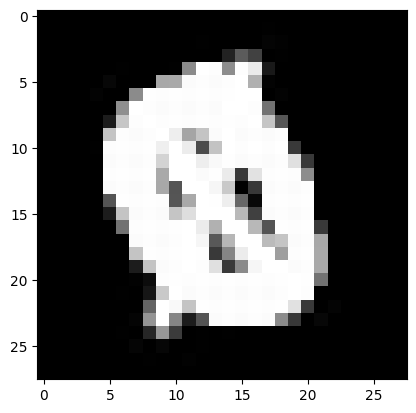

In [8]:

img = train_data[3][0]
img_permute = img.permute(1, 2, 0) #To shift the channels from 3rd index to 1st
plt.imshow(img_permute)

In [9]:
len(train_data) #To check if it contains all images

50

In [10]:
#Creating dataloader , to divide the images into batches and shuffeling the images to remove biases.
train_dataloader = DataLoader(dataset=train_data, 
                              batch_size=1, # how many samples per batch?
                              num_workers=1, # how many subprocesses to use for data loading? (higher = more)
                              shuffle=True) # shuffle the data?


In [11]:
next(iter(train_dataloader))[0].shape  #Checking the shape of dataloader , [batches, channels, width, height]

torch.Size([1, 3, 28, 28])

In [12]:
# Setting device agnostic code
device ='cuda' if torch.cuda.is_available() else 'cpu'

In [13]:
device

'cuda'

In [14]:
# Create a convolutional neural network 
class Model_for_checking_0orX(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, 
                      out_channels=hidden_units, 
                      kernel_size=3,
                      stride=1,
                      padding=1) ,
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from? 
            # It's because each layer of our network compresses and changes the shape of our inputs data.
            nn.Linear(in_features=hidden_units*7*7, 
                      out_features=output_shape)
        )
    
    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        # print(x.shape)
        x = self.block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x

model = Model_for_checking_0orX(input_shape=3, 
    hidden_units=100, 
    output_shape=len(train_data.classes))
model.to(device)

Model_for_checking_0orX(
  (block_1): Sequential(
    (0): Conv2d(3, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(100, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(100, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(100, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=4900, out_features=2, bias=True)
  )
)

In [15]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(),lr=0.01)

In [16]:
def accuracy_function(y_pred,y):
    return torch.eq(y_pred.argmax(1),y).sum().item()/len(y_pred)*100

In [17]:
train_loss, train_acc = 0, 0
epochs = 20
for epoch in range(epochs):
    train_loss = 0
    train_accuracy = 0
    for Batch,(X,y) in enumerate(iter(train_dataloader)):
        X = X.to(device)
        y = y.to(device)
        model.train()
        y_pred = model(X)
        loss = loss_fn(y_pred,y)
        train_loss +=loss
        accuracy = accuracy_function(y_pred,y) 
        train_accuracy+=accuracy
        optimizer.zero_grad()
        loss.backward()
        # print(loss)
        optimizer.step()
    print(f"{epoch+1}|Average loss: {(train_loss/len(train_dataloader))}|Average Accuracy:{(train_accuracy/len(train_dataloader))}%\n")

1|Average loss: 0.6905463933944702|Average Accuracy:54.0%

2|Average loss: 0.6986710429191589|Average Accuracy:50.0%

3|Average loss: 0.690943717956543|Average Accuracy:58.0%

4|Average loss: 0.6872804760932922|Average Accuracy:52.0%

5|Average loss: 0.6797364950180054|Average Accuracy:60.0%

6|Average loss: 0.665250837802887|Average Accuracy:64.0%

7|Average loss: 0.6299659013748169|Average Accuracy:78.0%

8|Average loss: 0.6044028997421265|Average Accuracy:70.0%

9|Average loss: 0.524016261100769|Average Accuracy:76.0%

10|Average loss: 0.45173180103302|Average Accuracy:82.0%

11|Average loss: 0.33090734481811523|Average Accuracy:92.0%

12|Average loss: 0.3057718575000763|Average Accuracy:82.0%

13|Average loss: 0.21594049036502838|Average Accuracy:92.0%

14|Average loss: 0.17680266499519348|Average Accuracy:90.0%

15|Average loss: 0.15966445207595825|Average Accuracy:96.0%

16|Average loss: 0.08732109516859055|Average Accuracy:98.0%

17|Average loss: 0.23023530840873718|Average Accu

In [18]:
y_pred = []
for x in range(len(train_data)):
    result = model(train_data[x][0].unsqueeze(0).to(device)).argmax(1) #Predicting values on training data-set using the model just trained
    y_pred.append(result) 

In [19]:
y_pred

[tensor([0], device='cuda:0'),
 tensor([0], device='cuda:0'),
 tensor([0], device='cuda:0'),
 tensor([0], device='cuda:0'),
 tensor([0], device='cuda:0'),
 tensor([0], device='cuda:0'),
 tensor([0], device='cuda:0'),
 tensor([0], device='cuda:0'),
 tensor([0], device='cuda:0'),
 tensor([0], device='cuda:0'),
 tensor([0], device='cuda:0'),
 tensor([0], device='cuda:0'),
 tensor([0], device='cuda:0'),
 tensor([0], device='cuda:0'),
 tensor([0], device='cuda:0'),
 tensor([0], device='cuda:0'),
 tensor([0], device='cuda:0'),
 tensor([0], device='cuda:0'),
 tensor([0], device='cuda:0'),
 tensor([0], device='cuda:0'),
 tensor([0], device='cuda:0'),
 tensor([0], device='cuda:0'),
 tensor([0], device='cuda:0'),
 tensor([0], device='cuda:0'),
 tensor([0], device='cuda:0'),
 tensor([1], device='cuda:0'),
 tensor([1], device='cuda:0'),
 tensor([1], device='cuda:0'),
 tensor([1], device='cuda:0'),
 tensor([1], device='cuda:0'),
 tensor([1], device='cuda:0'),
 tensor([1], device='cuda:0'),
 tensor(

In [20]:
class_names = train_data.classes


def is_equal(y_pred,y):
    if y_pred == y:
        return 1
    else:
        return 0

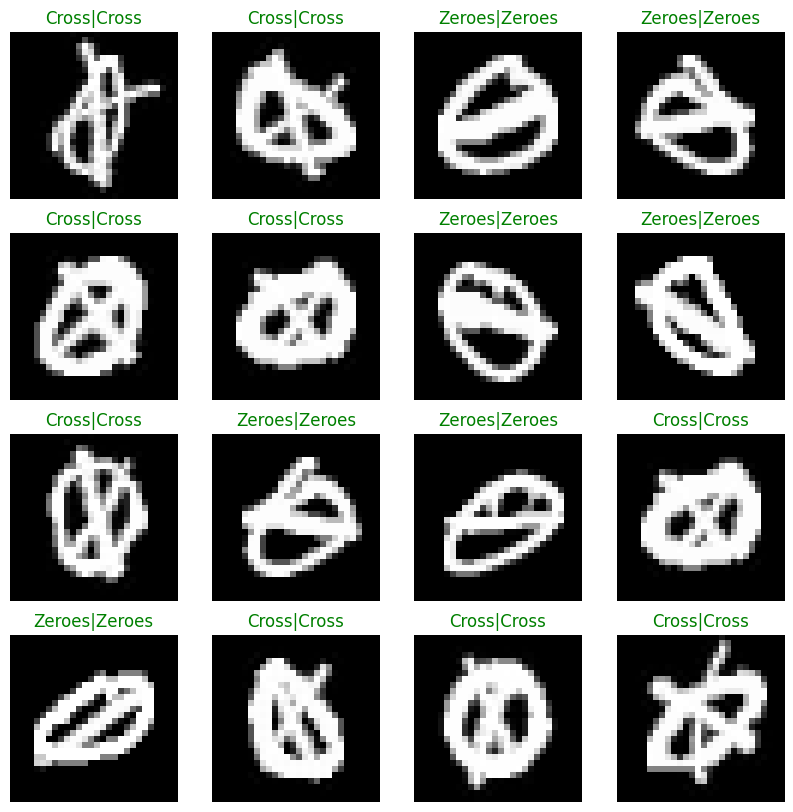

In [21]:
# Visualizing the results
No_of_values_to_predict = 16
plt.figure(figsize=(10,10))
Color = ['r','g']
list_indices = np.random.randint(0,len(train_data),16)
for x in range(16):
    plt.subplot(4,4,x+1)
    plt.imshow(train_data[list_indices[x]][0].squeeze().permute(1,2,0),cmap='gray')
    plt.title(f"{train_data.classes[y_pred[list_indices[x]]]}|{class_names[train_data[list_indices[x]][1]]}",c=Color[is_equal(y_pred[list_indices[x]],train_data.targets[list_indices[x]])])
    plt.axis('off')
plt.show()

#### Saving and loading the model

In [22]:

#! Saving the parameters of my beloved model.
# torch.save(obj=model.state_dict(),f="Model_1.pth")

# model.load_state_dict(torch.load(f="Model_1.pth")) #!To load the parameters already set for the model. 

In [56]:
grid_csv = pd.read_csv("icg-freshers-data-science-competition/Dataset/Train/Grid_labels.csv") #Reading grid.csv


In [68]:
# img=cv2.imread(a)
grid_path = Path("icg-freshers-data-science-competition/Dataset/Train/Grids")
blank_image = np.ones((26,26))*30
imagelist=[]
for x in range(len(grid_csv)):
    img_address = str(grid_csv["ID"][x])+".png"
    a = Path.joinpath(grid_path,img_address)
    print(a)
    images_grid1 = cv2.imread(str(a))
    images_grid1=images_grid1[60:420,145:505]
    img2 = images_grid1

    height, width,color_channels = img2.shape

    # Number of pieces Horizontally 
    W_SIZE  = 3 
    # Number of pieces Vertically to each Horizontal  
    H_SIZE = 3

    # Create a list to store sub-images for the current image
    current_image_parts = []

    for ih in range(H_SIZE):
        for iw in range(W_SIZE):
            x = width / W_SIZE * iw 
            y = height / H_SIZE * ih
            h = (height / H_SIZE)
            w = (width / W_SIZE)

            # Extract the sub-image
            img = img2[int(y):int(y + h), int(x):int(x + w)]
            img = cv2.resize(img, (28, 28))
            # Append the sub-image to the list for the current image
            current_image_parts.append(img)

    # Append the list of sub-images to the main list
    imagelist.append(current_image_parts)

icg-freshers-data-science-competition/Dataset/Train/Grids/58.png
icg-freshers-data-science-competition/Dataset/Train/Grids/160.png
icg-freshers-data-science-competition/Dataset/Train/Grids/162.png
icg-freshers-data-science-competition/Dataset/Train/Grids/287.png
icg-freshers-data-science-competition/Dataset/Train/Grids/500.png
icg-freshers-data-science-competition/Dataset/Train/Grids/618.png
icg-freshers-data-science-competition/Dataset/Train/Grids/886.png
icg-freshers-data-science-competition/Dataset/Train/Grids/1250.png
icg-freshers-data-science-competition/Dataset/Train/Grids/1587.png
icg-freshers-data-science-competition/Dataset/Train/Grids/1610.png
icg-freshers-data-science-competition/Dataset/Train/Grids/2154.png
icg-freshers-data-science-competition/Dataset/Train/Grids/2366.png
icg-freshers-data-science-competition/Dataset/Train/Grids/2425.png
icg-freshers-data-science-competition/Dataset/Train/Grids/2587.png
icg-freshers-data-science-competition/Dataset/Train/Grids/2591.png
icg

In [69]:
len(imagelist)

25

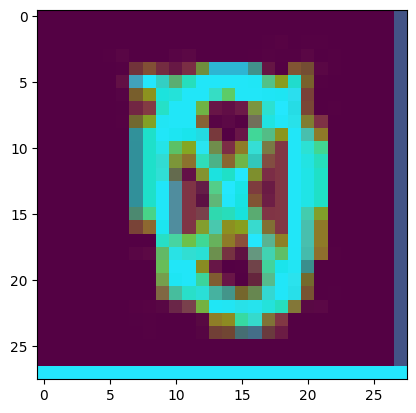

In [70]:
plt.imshow(imagelist[0][0])

/tmp/ipykernel_52200/3030208344.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  j =int(np.random.randint(0,len(imagelist),1))


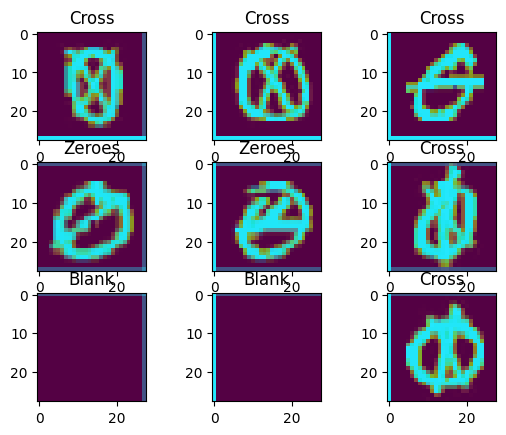

In [76]:

#! Result before trainging on grid_label.csv images
transform = transforms.ToTensor()  #To transform image into tensor and also making it so that value varies from -1 to 1
j =int(np.random.randint(0,len(imagelist),1))
for x in range(9):
    plt.subplot(3,3,x+1)
    # print("Inside Loop")
    plt.imshow(imagelist[j][x])
    if np.array_equal(blank_image,cv2.cvtColor(imagelist[j][x][1:27,1:27], cv2.COLOR_BGR2GRAY)):
        plt.title("Blank")
    else:
        y = model(transform(imagelist[j][x]).unsqueeze(0).to(device))
        plt.title(class_names[y.argmax(1)])
    # plt.show()

In [77]:
# grid_csv.reset_index(inplace=True)
list_map = []  #!It is a list which contains all the images of GRID mapped to their respective labels(in grid.csv)
for x in range(25):
    for y in range(9):
        if grid_csv.iloc[x,y+1] !=2:
            list_map.append([imagelist[x][y],grid_csv.iloc[x,y+1]])

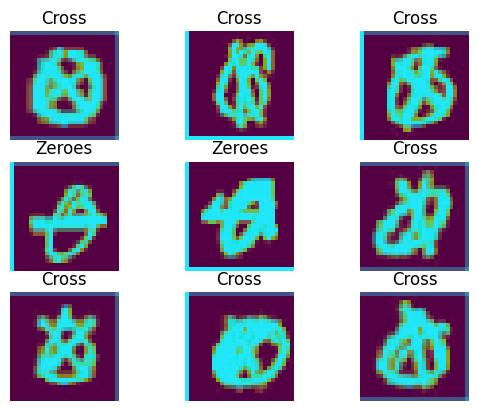

In [78]:
random_indices = np.random.randint(1,len(list_map),(9))
count = 1
for x in random_indices:
    plt.subplot(3,3,count)
    count +=1
    plt.imshow(list_map[x][0])
    plt.title(class_names[list_map[x][1]])
    plt.axis('off')
plt.show()

In [79]:
def accuracy_fn(y_pred,y): #Accuracy for Model predicting win or loss.
    return torch.eq(y_pred.argmax(1),y).sum().item()*100

In [81]:
images = []
labels= []
for x in list_map:
    #Splliting the data into images and labels
    images.append(Image.fromarray(x[0]))
    labels.append(x[1])

In [82]:

#! Creating a custom dataset. This is necessary to feed data into dataloader and subsiquently into the MODEL.
class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform
    def __len__(self):
        return len(self.images)
    def __getitem__(self, index):
        image = self.images[index]
        label = self.labels[index]

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label)  # Convert label to tensor if it's not already


# Create a custom dataset

custom_dataset = CustomDataset(images, labels, transform=data_transform)

# Create a DataLoader to handle batching and shuffling
batch_size = 32
shuffle = True
num_workers = 4  # Number of CPU processes to use for data loading
data_loader = DataLoader(custom_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)


In [85]:
train_loss, train_acc = 0, 0
epochs = 5
for epoch in range(epochs):
    train_loss = 0
    train_accuracy = 0
    for Batch,(X,y) in enumerate(iter(data_loader)):
        model.train()
        X = X.to(device)
        y = y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred,y)
        train_loss +=loss
        accuracy = accuracy_function(y_pred,y) 
        train_accuracy+=accuracy
        optimizer.zero_grad()
        loss.backward()
        # print(loss)
        optimizer.step()
    print(f"{epoch+1}|Average loss: {(train_loss/(Batch+1))}|Average Accuracy:{(train_accuracy/(Batch+1)):.2f}%\n")

1|Average loss: 0.07651948183774948|Average Accuracy:96.32%

2|Average loss: 0.07159095257520676|Average Accuracy:96.25%

3|Average loss: 0.07101144641637802|Average Accuracy:98.20%

4|Average loss: 0.06054821237921715|Average Accuracy:98.75%

5|Average loss: 0.0646093413233757|Average Accuracy:98.12%



#### Saving the model after modifying on grid data

In [87]:
# torch.save(obj=model.state_dict(), # only saving the state_dict() only saves the learned parameters
#             f="Model_1.pth")

### Training model to check who will win

In [89]:
y_expected = np.array(grid_csv['Decisions'])

In [90]:
y_expected = torch.tensor(y_expected)

In [91]:
X  = [] 
for x in range(len(grid_csv)):
    X.append(grid_csv.iloc[1,1:10])

In [92]:
X = []
for x in range(0,25):
    X.append(torch.tensor(grid_csv.iloc[x,1:10],dtype=torch.float))

/tmp/ipykernel_52200/1477014975.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  X.append(torch.tensor(grid_csv.iloc[x,1:10],dtype=torch.float))


In [169]:
class Model_Who_will_win(nn.Module):
    def __init__(self,input_features,hidden_units,output_features) -> None:
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            # nn.Flatten(),
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=output_features),
        )
    
    def forward(self, x):
        return self.linear_layer_stack(x)

In [170]:
model_predict = Model_Who_will_win(9,1000,3)
model_predict.to(device)

Model_Who_will_win(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=9, out_features=1000, bias=True)
    (1): Linear(in_features=1000, out_features=1000, bias=True)
    (2): Linear(in_features=1000, out_features=1000, bias=True)
    (3): Linear(in_features=1000, out_features=1000, bias=True)
    (4): Linear(in_features=1000, out_features=1000, bias=True)
    (5): Linear(in_features=1000, out_features=1000, bias=True)
    (6): Linear(in_features=1000, out_features=3, bias=True)
  )
)

In [181]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_predict.parameters(), 
                            lr=0.00001)

In [182]:
torch.tensor(grid_csv.iloc[1,1:10])

/tmp/ipykernel_52200/3667532071.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  torch.tensor(grid_csv.iloc[1,1:10])


tensor([0, 0, 1, 2, 2, 2, 0, 1, 1])

In [183]:
model_predict(X[0].to(device))


tensor([ 0.8769,  1.4369, -2.4688], device='cuda:0', grad_fn=<ViewBackward0>)

In [184]:
def accuracy_fn(y_pred,y):
    return torch.eq(y_pred,y).sum().item()/len(y_pred)*100

In [185]:
epochs = 1000
for epoch in range(epochs):
    y_pred = []
    total_loss,total_acc = 0,0
    for x in range(len(X)):
        # 1. Forward pass
        y_logits = model_predict(X[x].to(device)) # model outputs raw logits 
        y_pred.append(y_logits.argmax(0)) # go from logits -> prediction probabilities -> prediction labels
        # print(y_logits)
        # 2. Calculate loss and accuracy
        # y_pred = torch.tensor(y_pred,dtype = torch.float,requires_grad=True)
        loss = loss_fn(y_logits, y_expected[x].to(device))
        total_loss += loss 


        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backwards
        loss.backward()

        # 5. Optimizer step
        optimizer.step()
    y_pred = torch.tensor(y_pred,dtype=torch.float)
    y_pred.shape
    acc = accuracy_fn(y=y_expected,y_pred=y_pred)
    print(f"Epoch: {epoch} | Loss: {total_loss:.5f}, Acc: {acc:.2f}% ") 

Epoch: 0 | Loss: 16.52624, Acc: 64.00% 
Epoch: 1 | Loss: 16.52590, Acc: 64.00% 
Epoch: 2 | Loss: 16.52555, Acc: 64.00% 
Epoch: 3 | Loss: 16.52519, Acc: 64.00% 
Epoch: 4 | Loss: 16.52485, Acc: 64.00% 
Epoch: 5 | Loss: 16.52450, Acc: 64.00% 
Epoch: 6 | Loss: 16.52415, Acc: 64.00% 
Epoch: 7 | Loss: 16.52380, Acc: 64.00% 
Epoch: 8 | Loss: 16.52345, Acc: 64.00% 
Epoch: 9 | Loss: 16.52310, Acc: 64.00% 
Epoch: 10 | Loss: 16.52275, Acc: 64.00% 
Epoch: 11 | Loss: 16.52241, Acc: 64.00% 
Epoch: 12 | Loss: 16.52205, Acc: 64.00% 
Epoch: 13 | Loss: 16.52171, Acc: 64.00% 
Epoch: 14 | Loss: 16.52136, Acc: 64.00% 
Epoch: 15 | Loss: 16.52101, Acc: 64.00% 
Epoch: 16 | Loss: 16.52066, Acc: 64.00% 
Epoch: 17 | Loss: 16.52032, Acc: 64.00% 
Epoch: 18 | Loss: 16.51996, Acc: 64.00% 
Epoch: 19 | Loss: 16.51962, Acc: 64.00% 
Epoch: 20 | Loss: 16.51927, Acc: 64.00% 
Epoch: 21 | Loss: 16.51892, Acc: 64.00% 
Epoch: 22 | Loss: 16.51857, Acc: 64.00% 
Epoch: 23 | Loss: 16.51822, Acc: 64.00% 
Epoch: 24 | Loss: 16.51788

In [186]:


# ! Loading the model
# model_predict.load_state_dict(torch.load(f= 'Model_win_or_lose.pth'))

In [187]:
# torch.save(obj=model_predict.state_dict(), # only saving the state_dict() only saves the learned parameters
#            f="Model_win_or_lose.pth"))

In [188]:
# img=cv2.imread(a)

grid_path = Path("icg-freshers-data-science-competition/Dataset/Test")
imagelist_test=[]
items = []
for x in range(4520):
    img_address = str(x)+".png"
    a = Path.joinpath(grid_path,img_address)
    # print(a)
    try:
        images_grid1 = cv2.imread(str(a))
        images_grid1=images_grid1[60:420,145:505]
        img2 = images_grid1

        height, width,color_channels = img2.shape

        # Number of pieces Horizontally 
        W_SIZE  = 3 
        # Number of pieces Vertically to each Horizontal  
        H_SIZE = 3

        # Create a list to store sub-images for the current image
    except:
        continue
    current_image_parts = []

    items.append(x)
    for ih in range(H_SIZE):
        for iw in range(W_SIZE):
            x = width / W_SIZE * iw 
            y = height / H_SIZE * ih
            h = (height / H_SIZE)
            w = (width / W_SIZE)

            # Extract the sub-image
            img = img2[int(y):int(y + h), int(x):int(x + w)]
            img = cv2.resize(img, (28, 28))
            # Append the sub-image to the list for the current image
            current_image_parts.append(img)

    # Append the list of sub-images to the main list
    imagelist_test.append(current_image_parts)

[ WARN:0@3274.444] global loadsave.cpp:248 findDecoder imread_('icg-freshers-data-science-competition/Dataset/Test/58.png'): can't open/read file: check file path/integrity
[ WARN:0@3275.166] global loadsave.cpp:248 findDecoder imread_('icg-freshers-data-science-competition/Dataset/Test/160.png'): can't open/read file: check file path/integrity
[ WARN:0@3275.172] global loadsave.cpp:248 findDecoder imread_('icg-freshers-data-science-competition/Dataset/Test/162.png'): can't open/read file: check file path/integrity
[ WARN:0@3276.055] global loadsave.cpp:248 findDecoder imread_('icg-freshers-data-science-competition/Dataset/Test/287.png'): can't open/read file: check file path/integrity
[ WARN:0@3277.783] global loadsave.cpp:248 findDecoder imread_('icg-freshers-data-science-competition/Dataset/Test/500.png'): can't open/read file: check file path/integrity
[ WARN:0@3278.712] global loadsave.cpp:248 findDecoder imread_('icg-freshers-data-science-competition/Dataset/Test/618.png'): can't

In [189]:
items[-1]

4519

(<matplotlib.image.AxesImage at 0x7f69d70c8a00>, 0)

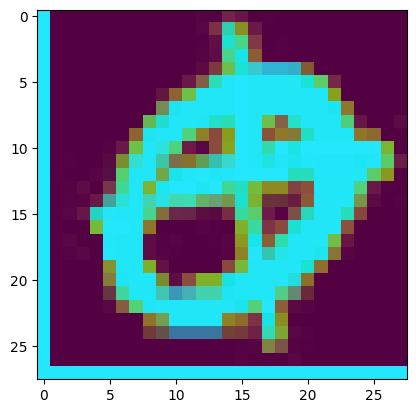

In [190]:
img = imagelist_test[0][1]
# img_permute = img.permute(1, 2, 0)
plt.imshow(img),items[0]

In [192]:
values = dict()
for j in range(len(imagelist_test)):
    pos_value = []
    for x in range(9):
        if np.array_equal(blank_image,cv2.cvtColor(imagelist_test[j][x][1:27,1:27], cv2.COLOR_BGR2GRAY)):
            pos_value.append(2)
        else:
            y = model(transform(imagelist_test[j][x]).unsqueeze(0).to(device))
            pos_value.append(int(y.argmax(1)))
    values[items[j]] = pos_value
    print(f"Done for {items[j]}.png|{j+1} items done!!")

Done for 0.png|1 items done!!
Done for 1.png|2 items done!!
Done for 2.png|3 items done!!
Done for 3.png|4 items done!!
Done for 4.png|5 items done!!
Done for 5.png|6 items done!!
Done for 6.png|7 items done!!
Done for 7.png|8 items done!!
Done for 8.png|9 items done!!
Done for 9.png|10 items done!!
Done for 10.png|11 items done!!
Done for 11.png|12 items done!!
Done for 12.png|13 items done!!
Done for 13.png|14 items done!!
Done for 14.png|15 items done!!
Done for 15.png|16 items done!!
Done for 16.png|17 items done!!
Done for 17.png|18 items done!!
Done for 18.png|19 items done!!
Done for 19.png|20 items done!!
Done for 20.png|21 items done!!
Done for 21.png|22 items done!!
Done for 22.png|23 items done!!
Done for 23.png|24 items done!!
Done for 24.png|25 items done!!
Done for 25.png|26 items done!!
Done for 26.png|27 items done!!
Done for 27.png|28 items done!!
Done for 28.png|29 items done!!
Done for 29.png|30 items done!!
Done for 30.png|31 items done!!
Done for 31.png|32 items do

In [193]:
for key in values.keys():
    decision = model_predict(torch.tensor(values[key],dtype=torch.float).to(device))
    values[key].append(int(decision.argmax(0)))
    print(f"Done for {key}.png !!")

Done for 0.png !!
Done for 1.png !!
Done for 2.png !!
Done for 3.png !!
Done for 4.png !!
Done for 5.png !!
Done for 6.png !!
Done for 7.png !!
Done for 8.png !!
Done for 9.png !!
Done for 10.png !!
Done for 11.png !!
Done for 12.png !!
Done for 13.png !!
Done for 14.png !!
Done for 15.png !!
Done for 16.png !!
Done for 17.png !!
Done for 18.png !!
Done for 19.png !!
Done for 20.png !!
Done for 21.png !!
Done for 22.png !!
Done for 23.png !!
Done for 24.png !!
Done for 25.png !!
Done for 26.png !!
Done for 27.png !!
Done for 28.png !!
Done for 29.png !!
Done for 30.png !!
Done for 31.png !!
Done for 32.png !!
Done for 33.png !!
Done for 34.png !!
Done for 35.png !!
Done for 36.png !!
Done for 37.png !!
Done for 38.png !!
Done for 39.png !!
Done for 40.png !!
Done for 41.png !!
Done for 42.png !!
Done for 43.png !!
Done for 44.png !!
Done for 45.png !!
Done for 46.png !!
Done for 47.png !!
Done for 48.png !!
Done for 49.png !!
Done for 50.png !!
Done for 51.png !!
Done for 52.png !!
Don

Done for 83.png !!
Done for 84.png !!
Done for 85.png !!
Done for 86.png !!
Done for 87.png !!
Done for 88.png !!
Done for 89.png !!
Done for 90.png !!
Done for 91.png !!
Done for 92.png !!
Done for 93.png !!
Done for 94.png !!
Done for 95.png !!
Done for 96.png !!
Done for 97.png !!
Done for 98.png !!
Done for 99.png !!
Done for 100.png !!
Done for 101.png !!
Done for 102.png !!
Done for 103.png !!
Done for 104.png !!
Done for 105.png !!
Done for 106.png !!
Done for 107.png !!
Done for 108.png !!
Done for 109.png !!
Done for 110.png !!
Done for 111.png !!
Done for 112.png !!
Done for 113.png !!
Done for 114.png !!
Done for 115.png !!
Done for 116.png !!
Done for 117.png !!
Done for 118.png !!
Done for 119.png !!
Done for 120.png !!
Done for 121.png !!
Done for 122.png !!
Done for 123.png !!
Done for 124.png !!
Done for 125.png !!
Done for 126.png !!
Done for 127.png !!
Done for 128.png !!
Done for 129.png !!
Done for 130.png !!
Done for 131.png !!
Done for 132.png !!
Done for 133.png 

In [195]:
Final_dataframe = pd.DataFrame(values).T
Final_dataframe.reset_index(inplace=True)
Final_dataframe.index = np.arange(1,len(values)+1)

In [196]:
Final_dataframe["ID"] = values.keys()
# Final_dataframe

,index,0,1,2,3,4,5,6,7,8,9
1,0,0,1,1,0,0,1,1,1,2,1
2,1,0,0,1,0,0,1,1,2,2,0
3,2,0,0,1,0,0,1,2,1,2,1
4,3,0,0,1,0,0,2,1,1,2,0
5,4,0,0,1,0,0,2,1,2,1,0
...,...,...,...,...,...,...,...,...,...,...,...
4491,4515,2,2,2,2,2,2,2,0,1,1
4492,4516,2,2,2,2,2,2,2,0,2,1
4493,4517,2,2,2,2,2,2,2,1,0,1
4494,4518,2,2,2,2,2,2,2,2,0,1


In [197]:
Final_dataframe.columns = ["ID","POS_1","POS_2","POS_3","POS_4","POS_5","POS_6","POS_7","POS_8","POS_9","Decision"]

In [ ]:
Final_dataframe.to_csv('Final_submission.csv', index=False)